# Deploying Flat-Bug

## Flat-bug setup

In [1]:
from flat_bug.predictor import Predictor

## Reproducible test setup
This part is only necessary if you don't have local test files (model weights/images) available. If you have them, you can skip this part.

In [2]:
import os
from urllib.request import urlretrieve

# We have sample weights and image available in a public repo
REMOTE_REPO = "https://anon.erda.au.dk/share_redirect/eU5VZ12Uzj/"

weights = "fb_YOLOv8M-seg.pt"
if not os.path.exists(weights):
    urlretrieve(REMOTE_REPO + "fb_YOLOv8M-seg.pt", weights)
image = "test_image.jpg"
if not os.path.exists(image):
    urlretrieve(REMOTE_REPO + "test_image.jpg", image)

## Usage

In [3]:
# Load the model
model = Predictor(weights, device="cuda:0")

# Predict
prediction = model.pyramid_predictions(image)

for k, v in prediction.json_data.items():
    if isinstance(v, list):
        instances = len(v)
        v = v[:min(3, instances)]
    print(f"{k}: {v}")

YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


/home/altair/micromamba/envs/fbc/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


boxes: [[2617, 1648, 2769, 1821], [915, 1589, 1104, 1802], [1394, 815, 1502, 961]]
contours: [[[2707.33349609375, 2704.0, 2702.0, 2700.0, 2698.0, 2695.33349609375, 2683.33349609375, 2672.0, 2670.0, 2668.0, 2666.0, 2664.0, 2662.0, 2660.0, 2658.0, 2656.0, 2654.0, 2652.0, 2650.0, 2648.0, 2646.0, 2644.0, 2642.0, 2640.0, 2638.0, 2635.33349609375, 2633.33349609375, 2632.0, 2630.0, 2627.33349609375, 2625.33349609375, 2624.0, 2627.33349609375, 2631.33349609375, 2634.0, 2636.0, 2639.33349609375, 2643.33349609375, 2661.33349609375, 2679.33349609375, 2681.33349609375, 2683.33349609375, 2685.33349609375, 2687.33349609375, 2689.33349609375, 2691.33349609375, 2694.0, 2696.0, 2699.33349609375, 2703.33349609375, 2707.33349609375, 2711.33349609375, 2719.33349609375, 2726.666748046875, 2728.666748046875, 2730.666748046875, 2732.666748046875, 2734.666748046875, 2736.666748046875, 2738.666748046875, 2740.666748046875, 2742.666748046875, 2744.666748046875, 2746.666748046875, 2748.666748046875, 2750.6667480

## Plot results

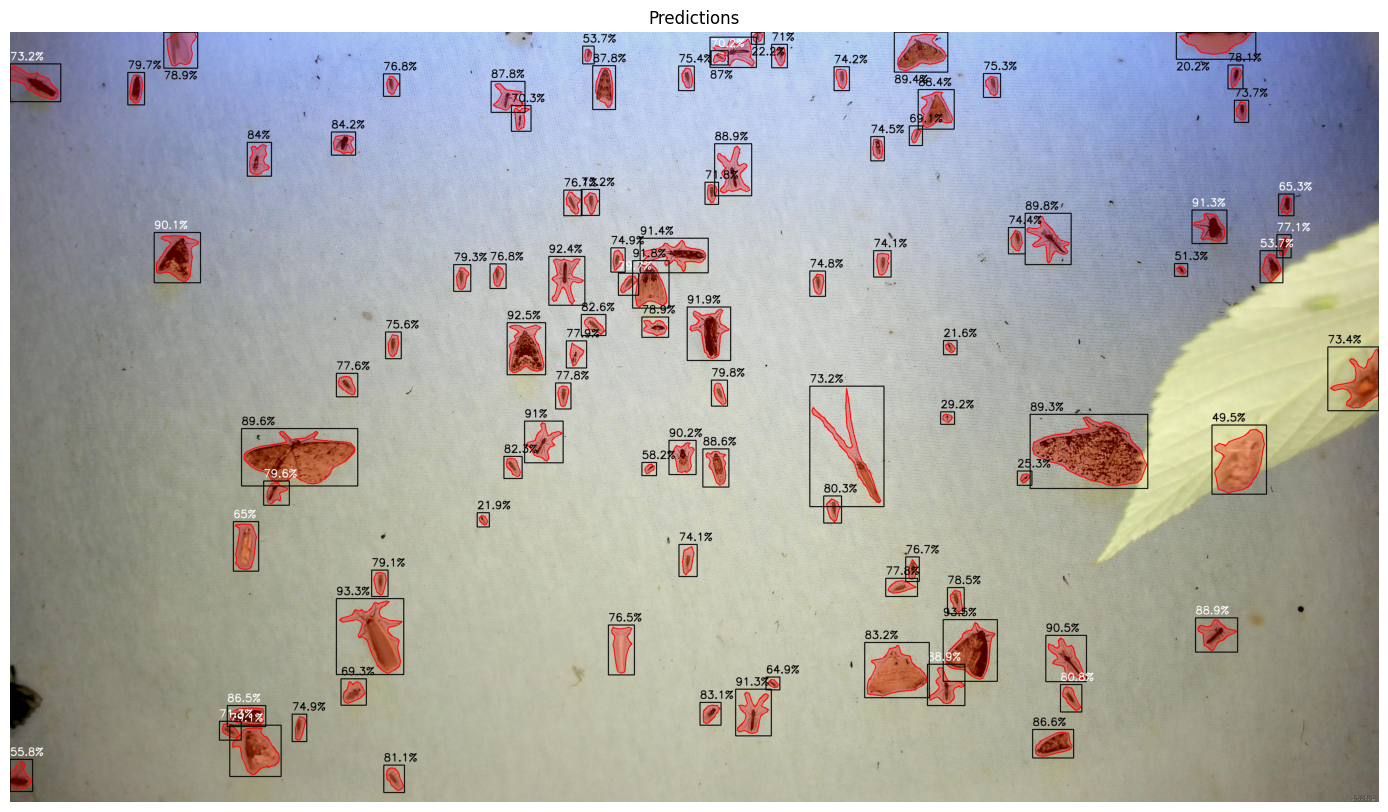

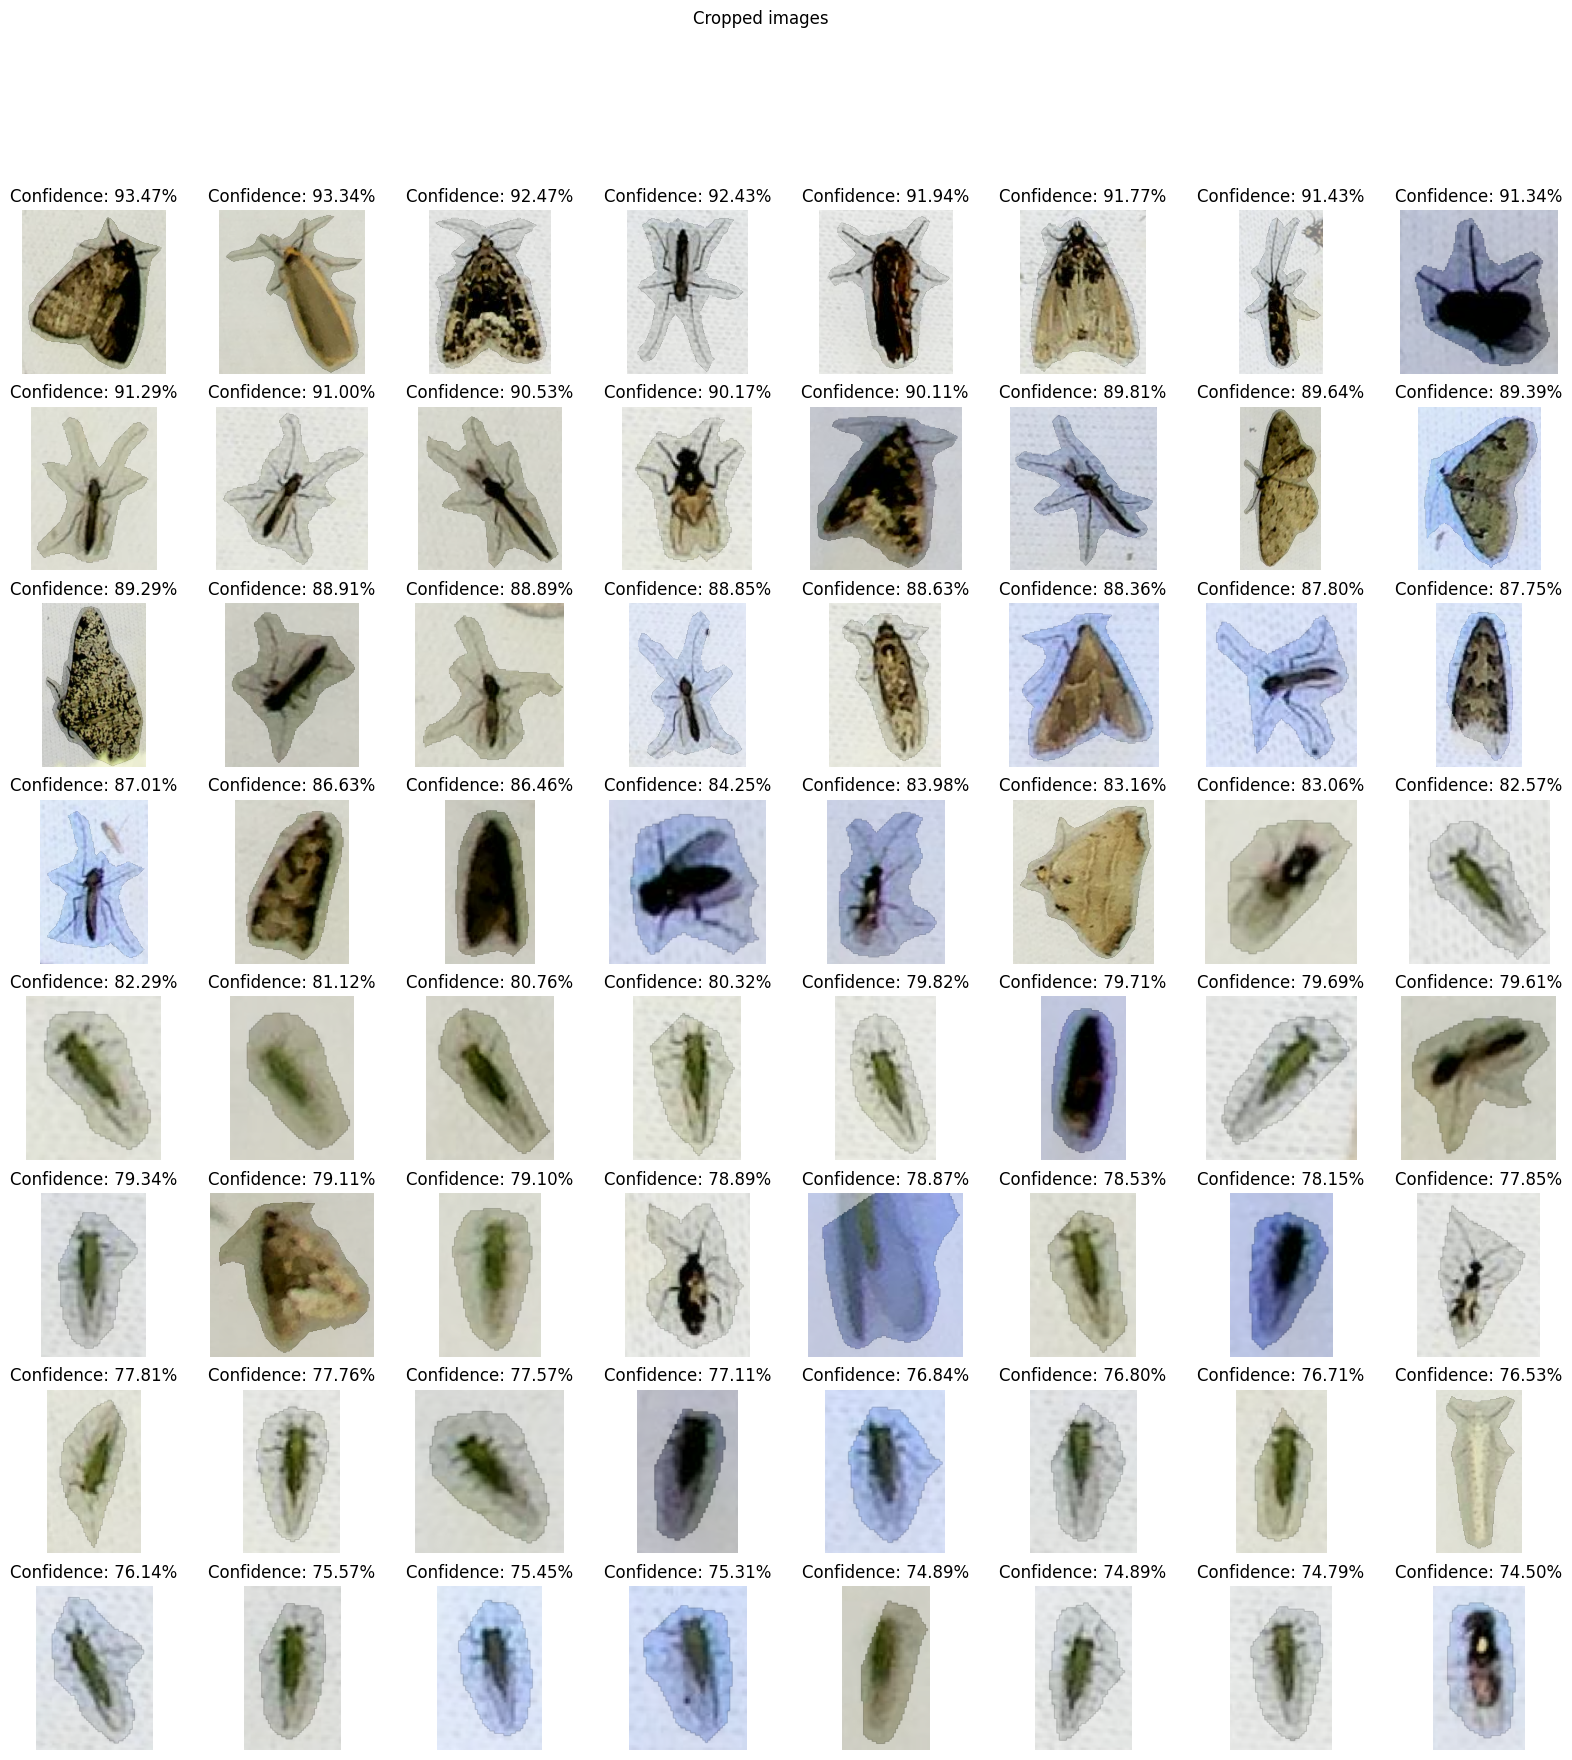

In [4]:
from matplotlib import pyplot as plt

# Plot all the predictions
plt.figure(figsize=(20, 10))
plt.imshow(prediction.plot())
plt.gca().axis("off")
plt.title("Predictions")
plt.show()

# Plot the cropped images
n_display = min(64, len(prediction))
crops, masks, confidences = prediction.crops[:n_display], prediction.crop_masks[:n_display], prediction.confs[:n_display]

n_crops = len(crops)
ncol = 8
nrow = n_crops // ncol
if n_crops % ncol:
    nrow += 1

fig, axs = plt.subplots(nrow, ncol, figsize=(2.5 * ncol, 2.5 * nrow))
axs = axs.flatten() if n_crops > 1 else [axs]
for ax, crop, mask, conf in zip(axs, crops, masks, confidences):
    crop = crop.permute(1, 2, 0).cpu()
    mask = 1 - mask.squeeze(0).cpu().float()
    w, h = mask.shape
    if w < h:
        mask = mask.transpose(1, 0)
        crop = crop.transpose(1, 0)
    ax.imshow(crop)
    ax.imshow(mask, cmap="gray", vmin=0, vmax=1, alpha=mask * 0.5) 
    ax.set_title(f"Confidence: {conf * 100:.2f}%")
    ax.axis("off")
plt.suptitle("Cropped images")
plt.show()